In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, accuracy_score

In [34]:
# Step 1: Load the dataset
file_path = '/content/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv'
data = pd.read_csv(file_path)

In [35]:
# Step 2: Clean column names
data.columns = data.columns.str.strip()

In [36]:
data

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,389,113095465,48,24,9668,10012,403,0,201.416667,203.548293,...,32,203985.500,5.758373e+05,1629110,379,13800000.0,4.277541e+06,16500000,6737603,BENIGN
1,389,113473706,68,40,11364,12718,403,0,167.117647,171.919413,...,32,178326.875,5.034269e+05,1424245,325,13800000.0,4.229413e+06,16500000,6945512,BENIGN
2,0,119945515,150,0,0,0,0,0,0.000000,0.000000,...,0,6909777.333,1.170000e+07,20400000,6,24400000.0,2.430000e+07,60100000,5702188,BENIGN
3,443,60261928,9,7,2330,4221,1093,0,258.888889,409.702161,...,20,0.000,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
4,53,269,2,2,102,322,51,51,51.000000,0.000000,...,32,0.000,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170361,55641,49,1,3,6,18,6,6,6.000000,0.000000,...,20,0.000,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
170362,45337,217,2,1,31,6,31,0,15.500000,21.920310,...,32,0.000,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
170363,22,1387547,41,46,2728,6634,456,0,66.536585,110.129945,...,32,0.000,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
170364,22,207,1,1,0,0,0,0,0.000000,0.000000,...,32,0.000,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN


In [37]:
# Step 3: Handle missing values (drop rows with missing values in 'Flow Bytes/s')
data = data.dropna(subset=['Flow Bytes/s'])

In [38]:
# Step 4: Encode the Label column (assuming binary classification)
label_encoder = LabelEncoder()
data['Label'] = label_encoder.fit_transform(data['Label'])

<ipython-input-38-f58e977cefcc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Label'] = label_encoder.fit_transform(data['Label'])


In [39]:
# Step 5: Split the data into features (X) and target (y)
X = data.drop(columns=['Label'])
y = data['Label']

In [40]:
# Step 6: Replace infinite values with NaN, then drop them
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(inplace=True)

In [41]:
# Step 7: Reindex y to match the cleaned X
y = y.loc[X.index]

In [42]:
# Step 8: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
# Step 9: Train a Random Forest model to determine feature importance
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [44]:
# Step 10: Use SelectFromModel to identify important features
selector = SelectFromModel(rf_model, prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [45]:
# Step 11: Get selected feature names
selected_importances = rf_model.feature_importances_[selector.get_support()]
selected_features = X.columns[selector.get_support()].tolist()
print("Selected Features:", selected_features)

Selected Features: ['Destination Port', 'Flow Duration', 'Total Length of Fwd Packets', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Fwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Max Packet Length', 'Packet Length Mean', 'Average Packet Size', 'Fwd Header Length.1', 'Subflow Fwd Bytes', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward']


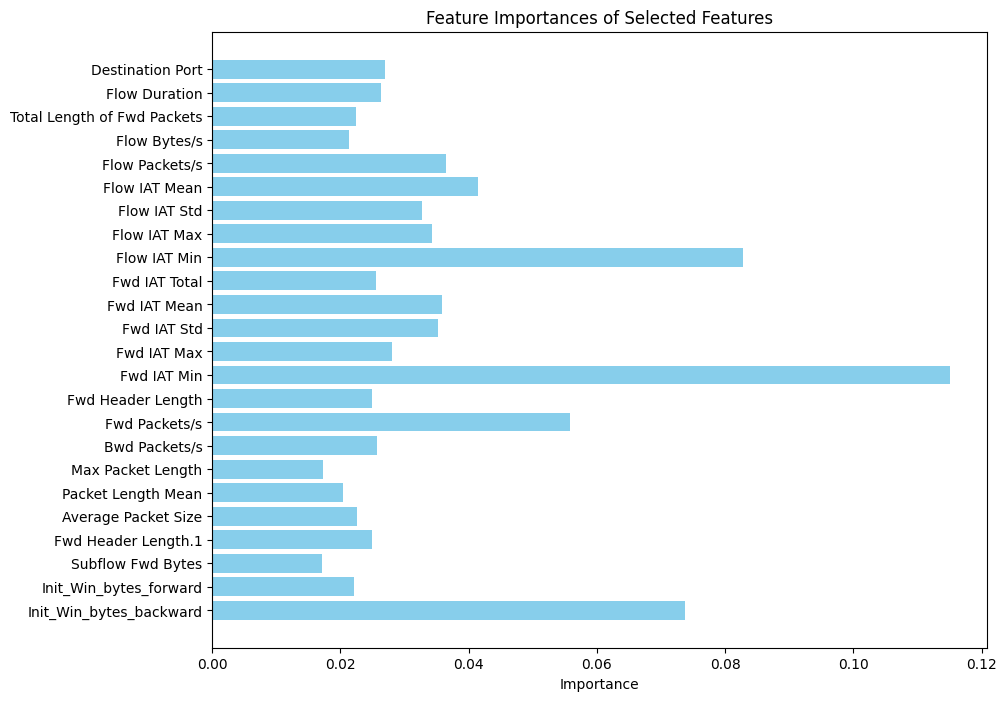

In [46]:
# Step 12: Visualize the Selected Features
plt.figure(figsize=(10, 8))
plt.barh(selected_features, selected_importances, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances of Selected Features')
plt.gca().invert_yaxis()  # To display the highest importance feature at the top
plt.show()

In [47]:
# Step 13: Train the Random Forest model on the selected features
rf_model.fit(X_train_selected, y_train)

RandomForestClassifier(random_state=42)

In [48]:
# Step 13: Make predictions on the test set
y_pred = rf_model.predict(X_test_selected)

In [49]:
# Step 14: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [50]:
# Print Accuracy and The Report
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.9956530678180163
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     33603
           1       0.80      0.77      0.79       324
           2       1.00      0.17      0.29         6
           3       0.39      0.40      0.40       114

    accuracy                           1.00     34047
   macro avg       0.80      0.59      0.62     34047
weighted avg       1.00      1.00      1.00     34047

